# 尝试运行模型

Jupyter notebook 是交互式的代码IDE，非常适合新手，建议最开始在这里探索我们的模型。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

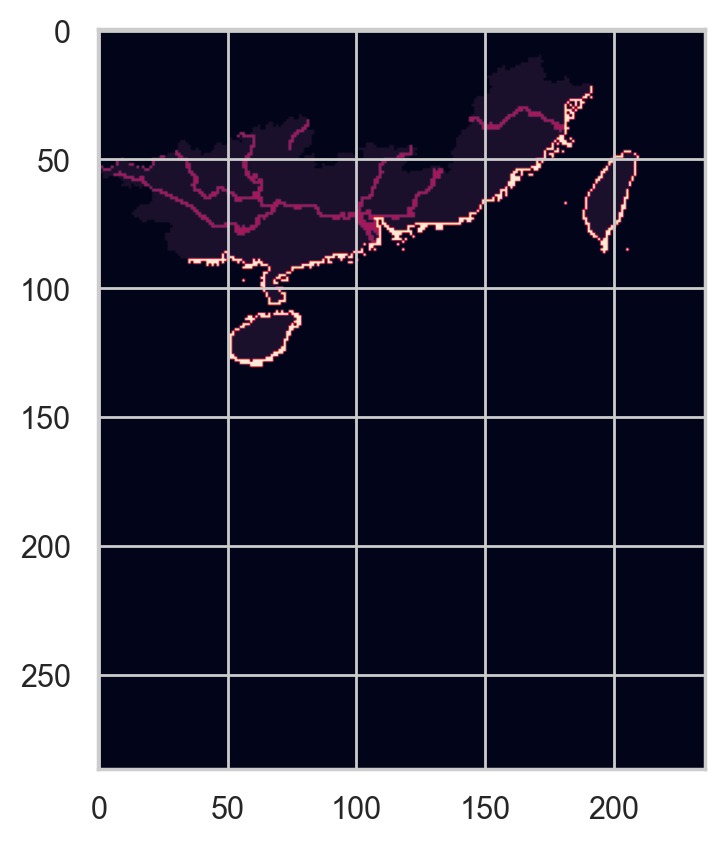

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid")

import rasterio

with rasterio.open(cfg.db.lim_h) as dataset:
    arr = dataset.read(1)
    plt.imshow(arr)

注意下面这里需要把你上面读取的参数配置文件，作为参数`parameters=cfg`输入到模型中。

In [3]:
# 从这个路径加载模型
from abses_sce.model import Model

model = Model(parameters=cfg)
model.params.save_plots = False

增加了初始的 Hunters，随机生成在地图上

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

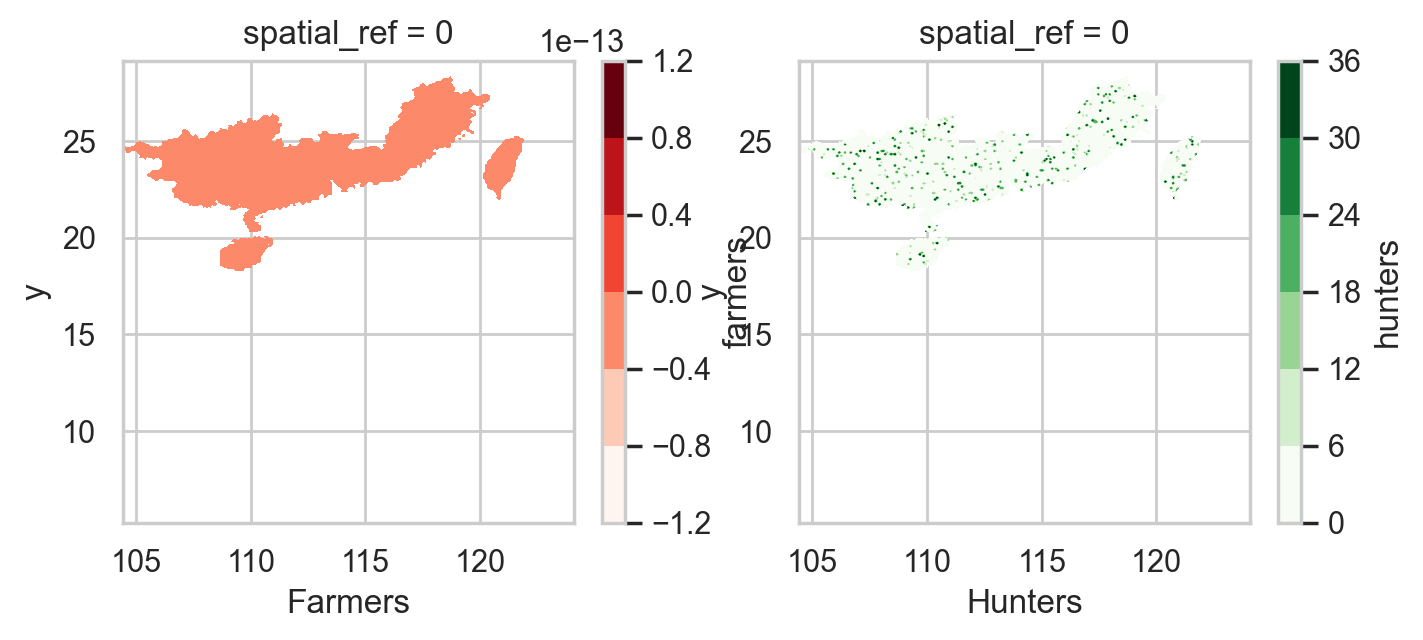

In [4]:
model.plot.heatmap()

设置100年的话，模型的运行可能需要几分钟的时间，以此类推，模型没运算完不要太着急。完成后会自动做出下面的折线图。

tick[10] 2023-12-09 19:18:54

/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_ol

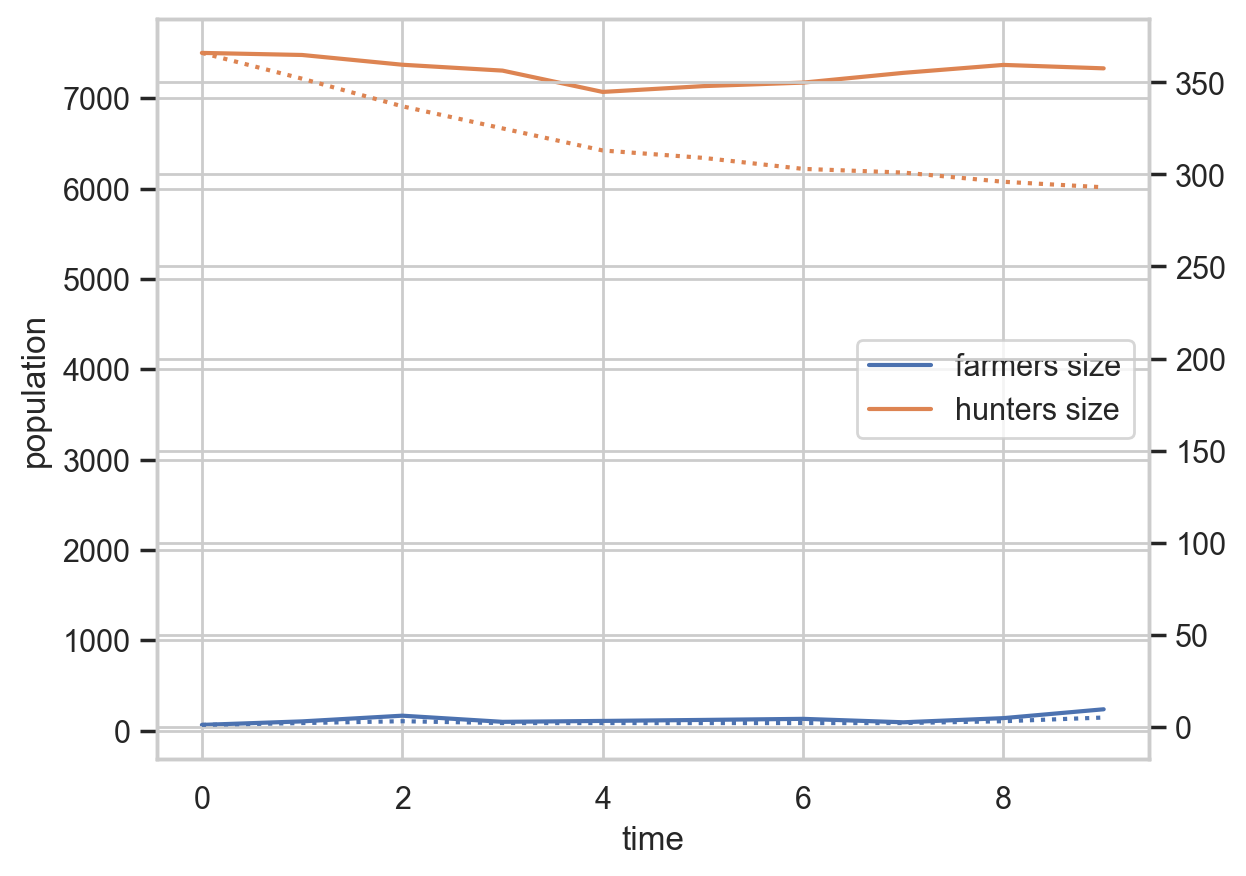

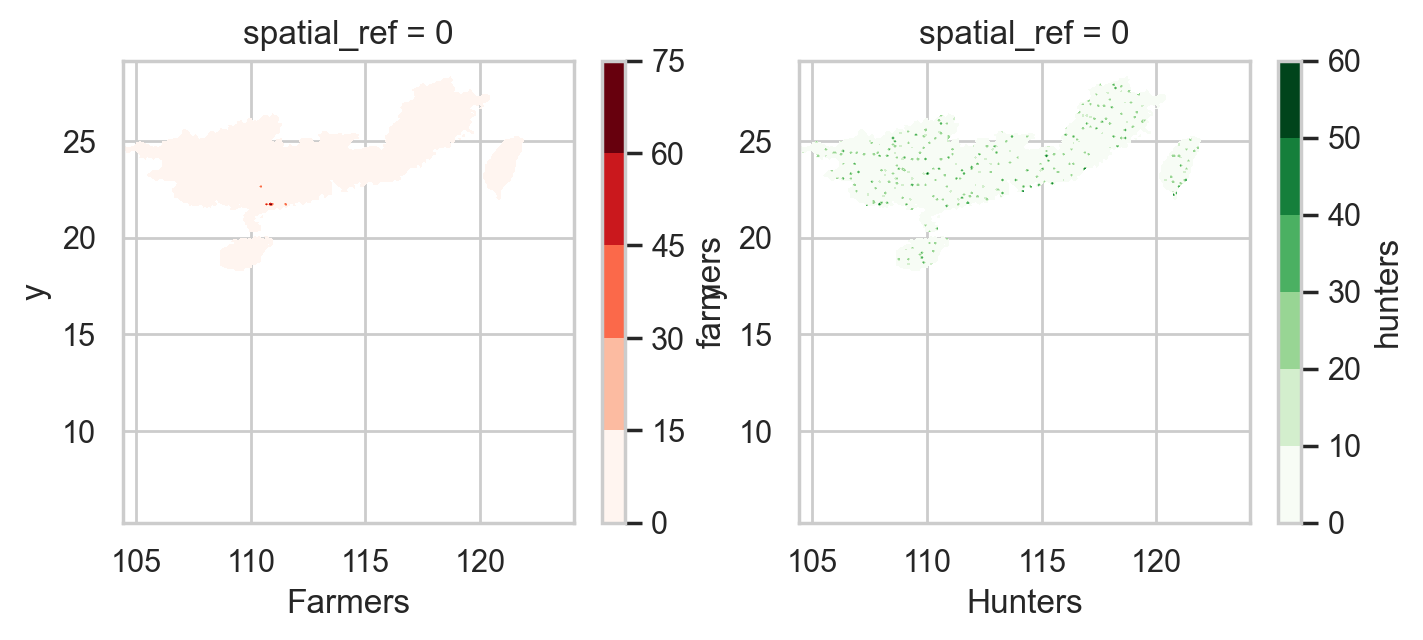

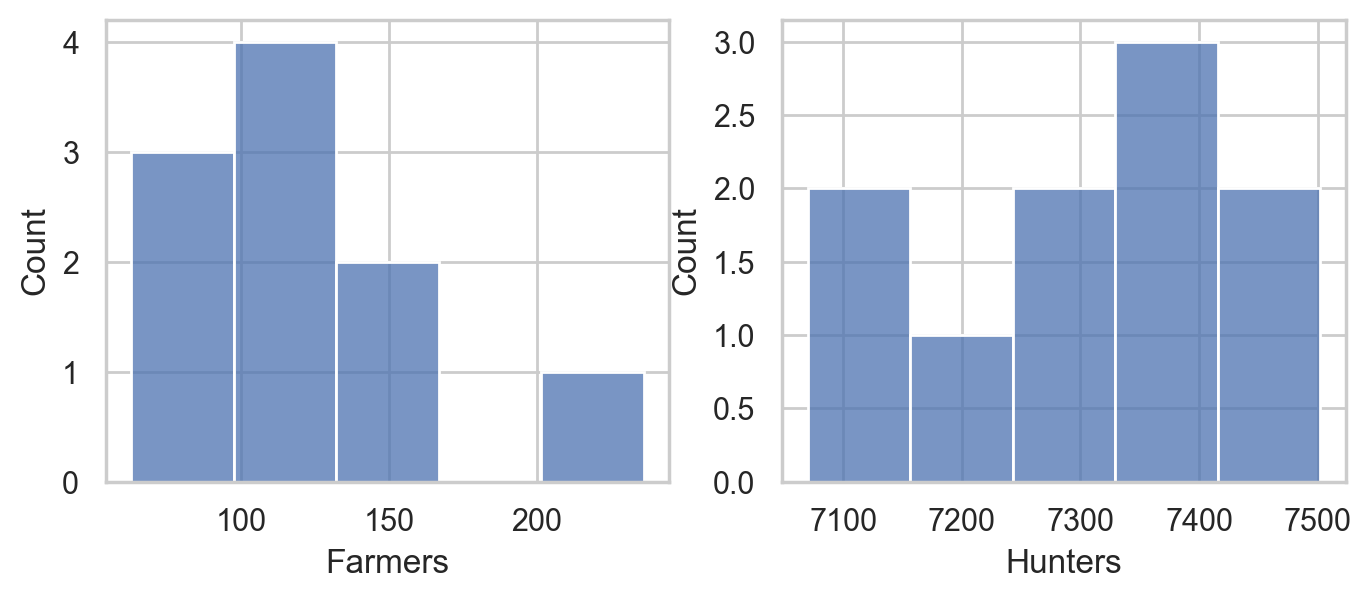

In [5]:
model.run_model()

展示主体的信息

In [6]:
agent = model.agents.to_list().random.choice()
agent.report()

unique_id           141
breed            Hunter
size               14.0
position     (168, 267)
dtype: object

(<Axes: title={'center': 'spatial_ref = 0'}, xlabel='Farmers', ylabel='y'>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='Hunters', ylabel='y'>)

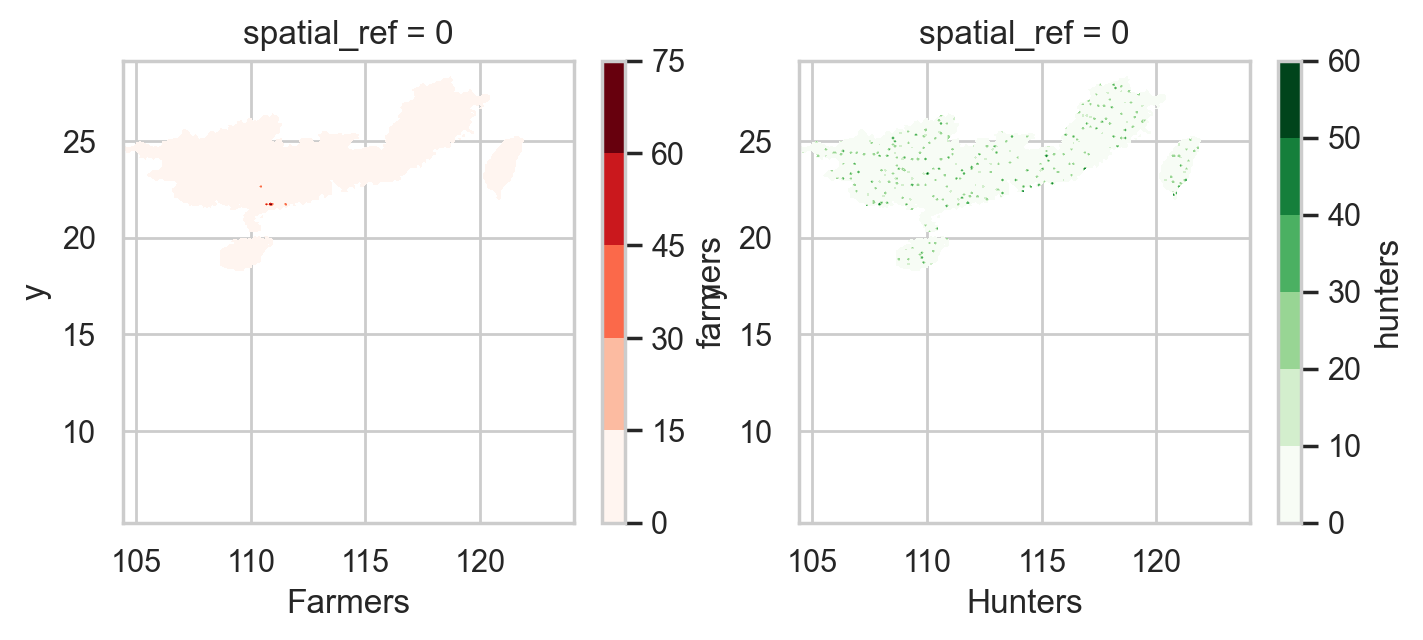

In [7]:
model.plot.heatmap()

In [8]:
for cell in model.nature.dem.array_cells.ravel():
    if len(cell.agents) > 1:
        cell.agents

In [9]:
model.hunters
model.farmers

<ActorsList: (293)Hunter>

<ActorsList: (5)Farmer>

<Axes: xlabel='time', ylabel='population'>

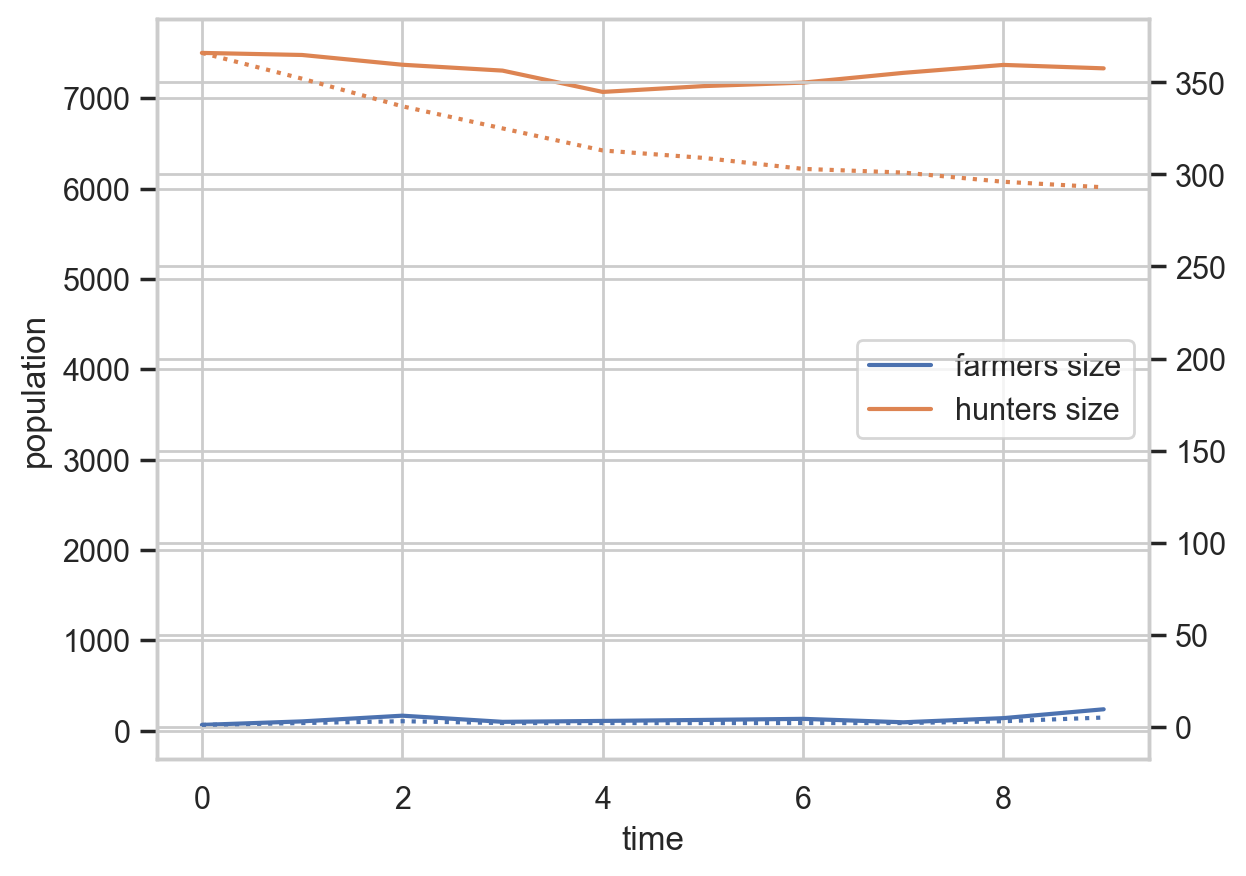

In [10]:
model.plot.dynamic()

/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/songshgeo/Documents/VSCode/SC-20230710-SCE/.venv/lib/python3.11/site-packages/seaborn/_ol

(<Axes: xlabel='Farmers', ylabel='Count'>,
 <Axes: xlabel='Hunters', ylabel='Count'>)

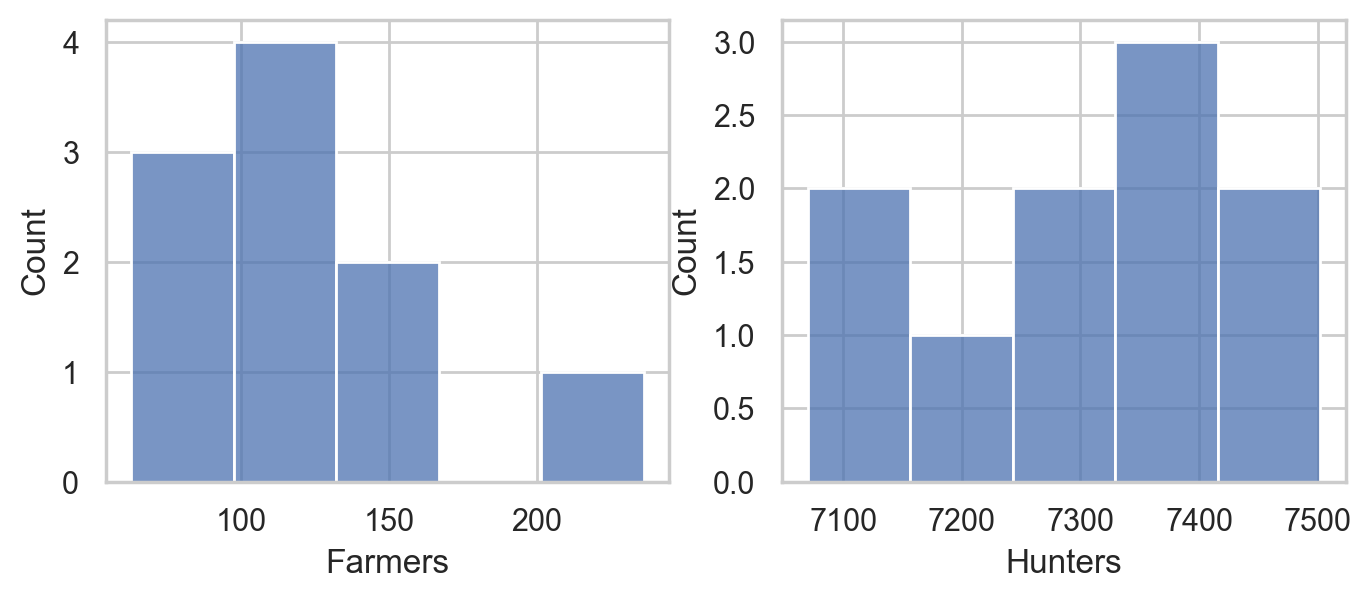

In [11]:
import seaborn as sns

model.plot.histplot()